# Data Validation Report for `validation_test_case`


It is a test assignment focused on verifying the accuracy of an AI-based ticket classification system.
The dataset contains tickets, which are customer reviews or opinions about a company (in this case, Booking).
The system automatically classifies each ticket into five predefined topics and determines the sentiment for each topic (positive, negative, or neutral).

In the first part of report, I import data from two JSON files, validate their data, and eliminate the possibility of empty lines. In the second, I process and compare the obtained data. In the third, I display graphs demonstrating the data and draw a conclusion on the work done.

In [10]:
import pandas as pd
from collections import Counter

clean_tickets = pd.json_normalize(pd.read_json('json_file_for_validation/booking_reviews_clean.json')['tickets'])

results_json = pd.read_json('json_file_for_validation/results_booking_reviews_clean.json')

print(f'Duplicates found in result data is {results_json.size - results_json.drop_duplicates().size}')

results_json = results_json.drop_duplicates();
results_raw = results_json["gemini-2.5-flash"]

all_blocks = [item for sublist in results_raw for item in sublist]

results_rows = []
for block in all_blocks:
    for ex in block["examples"]:
        results_rows.append({
            "subtopic": block["subtopic"],
            "sentiment": block["sentiment"],
            "example_text": ex.strip().lower(),
        })

results_tickets_flat = pd.DataFrame(results_rows)

print(f'Size clean_tickets is {clean_tickets.size}')
print(clean_tickets.head(), end='\n\n')

print(f'Size results_tickets is {results_tickets_flat.size}')
print(results_tickets_flat.head(), end='\n\n')

Duplicates found in result data is 3
Size clean_tickets is 2034
                                    original_message  \
0  Not to gush, but support has genuinely helped ...   
1  Over the weekend, the rewards points actually ...   
2  Not to gush, but support has genuinely helped ...   
3  While traveling abroad, the app froze twice on...   
4  For a family visit, the property was overbooke...   

                                        message_text sentiment__filter  
0  not to gush, but support has genuinely helped ...          Positive  
1  over the weekend, the rewards points actually ...          Positive  
2  not to gush, but support has genuinely helped ...          Positive  
3  while traveling abroad, the app froze twice on...          Negative  
4  for a family visit, the property was overbooke...          Negative  

Size results_tickets is 807
                       subtopic sentiment  \
0  Unexpected Charges & Pricing  Negative   
1  Unexpected Charges & Pricing  Negative 

To validate model output against the ground-truth dataset, we normalize the text and build a hash map that maps each unique message to its true sentiment.

In [11]:
df = clean_tickets.dropna(subset=['message_text']).copy()
df['norm_text'] = (
    df['message_text'].str.lower().str.strip().str.replace(r'\s+', ' ', regex=True)
)

sentiment_map = {}
for text, group in df.groupby('norm_text'):
    sentiments = group['sentiment__filter'].tolist()
    most_common = Counter(sentiments).most_common(1)[0][0]
    sentiment_map[text] = most_common

print(f"Total number of unique texts in RAW: {len(sentiment_map)}")

Total number of unique texts in RAW: 358


After constructing the hash-map of normalized messages and their true sentiment labels, we expand the model output and compare each example response against the ground-truth sentiment. Each generated example is matched to its original user review (based on normalized text), and we verify whether the detected sentiment aligns with the sentiment in the source dataset. Any discrepancies are surfaced as sentiment mismatches, providing a clear view of model accuracy and potential failure cases.

In [12]:
results_tickets_flat['norm_text'] = results_tickets_flat['example_text'].str.lower().str.strip()

raw_texts = list(sentiment_map.keys())

def check_sentiment(row):
    example = row['norm_text']

    if example in sentiment_map:
        raw_sent = sentiment_map[example]
    else:
        match = next((txt for txt in raw_texts if example in txt), None)
        if match:
            raw_sent = sentiment_map[match]
        else:
            return "not_found"

    return "match" if raw_sent == row['sentiment'] else "mismatch"

results_tickets_flat['sentiment_check'] = results_tickets_flat.apply(check_sentiment, axis=1)

This step calculates the overall sentiment validation statistics. It counts how many model-generated examples correctly match the ground-truth sentiment, how many disagree, and how many cannot be found in the original dataset. Based on these counts, it computes the sentiment accuracy and outputs sample mismatched cases as well as examples missing from the raw data. This provides a clear quantitative and qualitative view of model performance.

In [13]:
total = len(results_tickets_flat)
matches = (results_tickets_flat['sentiment_check'] == 'match').sum()
mismatches = (results_tickets_flat['sentiment_check'] == 'mismatch').sum()
not_found = (results_tickets_flat['sentiment_check'] == 'not_found').sum()

print(f"Total examples: {total}")
print(f"Sentiment matches: {matches}")
print(f"Sentiment mismatches: {mismatches}")
print(f"Not found in RAW: {not_found}")

if matches + mismatches > 0:
    print(f"Sentiment Accuracy: {matches / (matches + mismatches):.2%}\n")

print("\n Mismatched examples:")
print(results_tickets_flat[results_tickets_flat['sentiment_check'] == 'mismatch'][['example_text','sentiment']].head())

print("\n Examples not found in RAW:")
print(results_tickets_flat[results_tickets_flat['sentiment_check'] == 'not_found'][['example_text']].head())


Total examples: 269
Sentiment matches: 243
Sentiment mismatches: 23
Not found in RAW: 3
Sentiment Accuracy: 91.35%


 Mismatched examples:
                                         example_text sentiment
17              app lags when you zoom around the map  Negative
18  results were mostly accurate though a bit slow...  Negative
19                               search fine but slow  Negative
23  results were mostly accurate though a bit slow...  Negative
24                               search fine but slow  Negative

 Examples not found in RAW:
                               example_text
145            cost me hundreds for nothing
146  charged me for a booking i didn't take
147  insane charged me for flat i cancelled


Below I provide graphs that process this data.

Sentiment Validation Results (match / mismatch / not found)

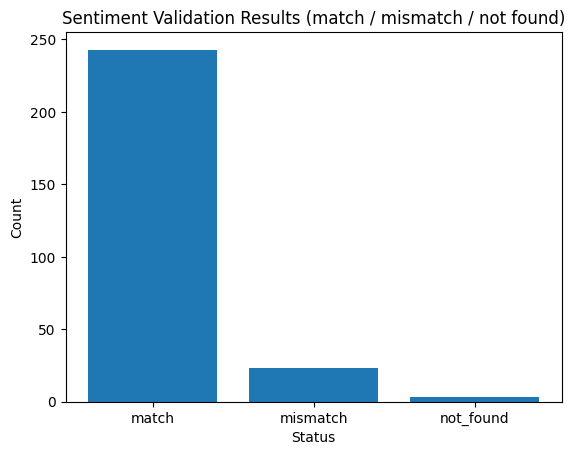

In [14]:
import matplotlib.pyplot as plt
import numpy as np


results_tickets_flat['raw_sent'] = results_tickets_flat['norm_text'].map(sentiment_map)
results_tickets_flat['sentiment_check'] = results_tickets_flat.apply(check_sentiment, axis=1)

summary_counts = results_tickets_flat['sentiment_check'].value_counts().reindex(['match','mismatch','not_found']).fillna(0)

plt.figure()
plt.bar(summary_counts.index, summary_counts.values)
plt.title('Sentiment Validation Results (match / mismatch / not found)')
plt.ylabel('Count')
plt.xlabel('Status')
plt.show()

'match', 'mismatch' and 'not fount' per Sentiment Class

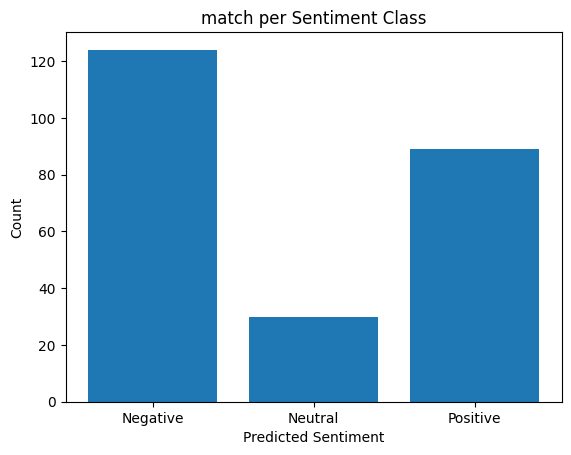

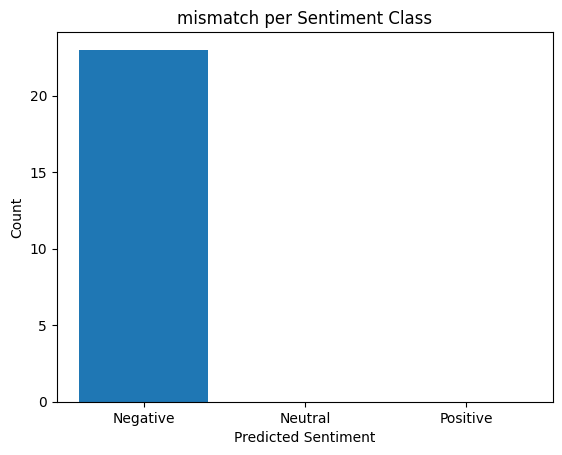

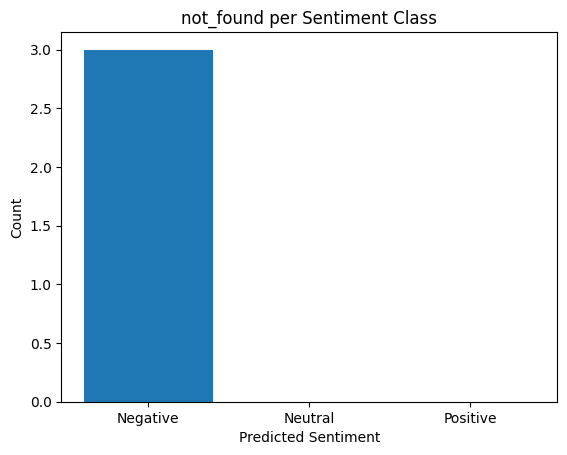

In [15]:
by_sent = (
    results_tickets_flat
    .groupby(['sentiment','sentiment_check'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=['match','mismatch','not_found'])
    .fillna(0)
)

for col in by_sent.columns:
    plt.figure()
    plt.bar(by_sent.index.astype(str), by_sent[col].values)
    plt.title(f'{col} per Sentiment Class')
    plt.ylabel('Count')
    plt.xlabel('Predicted Sentiment')
    plt.show()

I consider the most effective list to be the Confusion Matrix, which anticipates and explains my conclusion about the validation of this data.

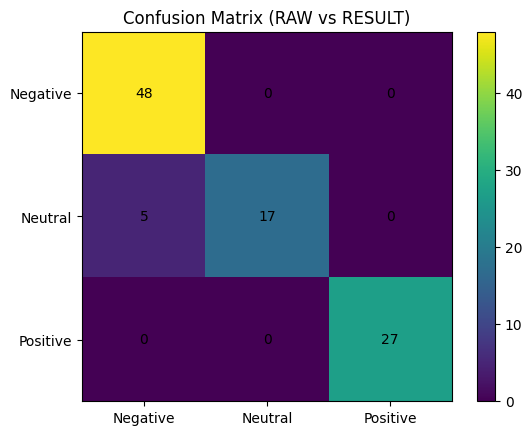

In [16]:
conf = (
    results_tickets_flat[results_tickets_flat['sentiment_check'] != 'not_found']
    .groupby(['raw_sent','sentiment'])
    .size()
    .unstack(fill_value=0)
)

plt.figure()
im = plt.imshow(conf.values)
plt.title('Confusion Matrix (RAW vs RESULT)')
plt.xticks(np.arange(conf.shape[1]), conf.columns)
plt.yticks(np.arange(conf.shape[0]), conf.index)

for i in range(conf.shape[0]):
    for j in range(conf.shape[1]):
        plt.text(j, i, int(conf.values[i, j]), ha="center", va="center")

plt.colorbar(im)
plt.show()

Based on the manipulations and data presented above, I believe the model has the greatest validation challenges with negative and neutral data. Below, I'll also perform a volume validation. To summarize, Sentiment Accuracy is 91.62%, which is a good indicator. The model has difficulty differentiating between neutral and negative reviews.

# Topic Volume Validation Overview

For each topic, the model provided a predicted percentage and a set of search terms. These terms were applied to the raw dataset to approximate the true share of reviews belonging to each topic. We then compared the model’s predicted percentages against the observed values.

## Column Definitions

*subtopic* — topic label assigned by the model

*expected_pct* — percentage of reviews the model claims belong to this topic

*actual_pct* — actual percentage of reviews associated with the topic based on raw data matching

*difference_pp* — absolute difference between expected and actual topic share (percentage points)

*found_reviews* — number of raw reviews matched to the topic

*abs_pct_error* — proportional error between expected and actual values

*direction* — indicates whether the model over- or under-estimated the topic volume

## Evaluation Metrics

*MAE* (Mean Absolute Error) — average deviation in percentage points between predicted and true topic shares

*MAPE* (Mean Absolute Percentage Error) — average relative error showing how far predictions are from true values in percentage terms

*RMSE* (Root Mean Squared Error) — error measure that penalizes larger deviations more strongly

*Recall @ ±5pp* — percentage of topics where the model’s estimate was within ±5 percentage points of the actual value

In [17]:
clean = clean_tickets.copy()
clean['norm_text'] = (
    clean['message_text']
    .str.lower()
    .str.strip()
    .str.replace(r'\s+', ' ', regex=True)
)

results = results_json.copy()
results = results.drop_duplicates()
blocks = [item for sublist in results["gemini-2.5-flash"] for item in sublist]

topic_stats = []

for block in blocks:
    subtopic = block['subtopic']
    expected_pct = block['percent']

    terms = [t.strip().lower() for t in block['search_query'].split('+')]
    mask = clean['norm_text'].apply(lambda txt: any(term in txt for term in terms))

    found_count = mask.sum()
    total = len(clean)
    actual_pct = round((found_count / total * 100), 2) if total > 0 else 0

    topic_stats.append({
        "subtopic": subtopic,
        "expected_pct": round(expected_pct, 2),
        "actual_pct": actual_pct,
        "difference_pp": round(abs(expected_pct - actual_pct), 2),
        "found_reviews": found_count
    })

topic_report = pd.DataFrame(topic_stats)
print(f'DataSet size is {total}')

MAE_pp = round(topic_report['difference_pp'].mean(), 2)
topic_report['abs_pct_error'] = np.where(
    topic_report['expected_pct'] > 0,
    abs(topic_report['actual_pct'] - topic_report['expected_pct']) / topic_report['expected_pct'],
    np.nan
)
MAPE = round(topic_report['abs_pct_error'].mean() * 100, 2)
RMSE = round(np.sqrt((topic_report['difference_pp']**2).mean()), 2)

threshold = 5
recall = round((topic_report['difference_pp'] <= threshold).mean() * 100, 2)

topic_report['direction'] = np.where(
    topic_report['actual_pct'] > topic_report['expected_pct'], 'Over', 'Under'
)

print("=== Topic Volume Validation ===\n")
display(topic_report.sort_values("expected_pct", ascending=False))

print("\n=== Metrics ===")
print(f"MAE (pct points): {MAE_pp}")
print(f"MAPE (%): {MAPE}")
print(f"RMSE (pct points): {RMSE}")
print(f"Recall @ {threshold} p.p.: {recall}%")

print("\nOver-reported topics:")
display(topic_report[topic_report["direction"] == "Over"][['subtopic','expected_pct','actual_pct','difference_pp']])

print("\nUnder-reported topics:")
display(topic_report[topic_report["direction"] == "Under"][['subtopic','expected_pct','actual_pct','difference_pp']])


DataSet size is 678
=== Topic Volume Validation ===



,subtopic,expected_pct,actual_pct,difference_pp,found_reviews,abs_pct_error,direction
5,Ease of Booking & Confirmation,25,11.50,13.50,78,0.540000,Under
14,Positive Booking Experience,20,10.18,9.82,69,0.491000,Under
12,Booking Discrepancies,17,10.03,6.97,68,0.410000,Under
0,Unexpected Charges & Pricing,15,9.44,5.56,64,0.370667,Under
9,Unexpected Charges & Fees,15,10.32,4.68,70,0.312000,Under
8,Interface & Navigation,13,9.29,3.71,63,0.285385,Under
17,General App Usability,13,21.83,8.83,148,0.679231,Over
2,Property & Booking Discrepancies,12,10.03,1.97,68,0.164167,Under
1,App Stability & Performance,10,9.88,0.12,67,0.012000,Under
6,Effective Customer Support,8,3.69,4.31,25,0.538750,Under



=== Metrics ===
MAE (pct points): 5.02
MAPE (%): 47.72
RMSE (pct points): 6.0
Recall @ 5 p.p.: 61.11%

Over-reported topics:


,subtopic,expected_pct,actual_pct,difference_pp
10,App Stability & Performance,8,9.88,1.88
17,General App Usability,13,21.83,8.83



Under-reported topics:


,subtopic,expected_pct,actual_pct,difference_pp
0,Unexpected Charges & Pricing,15,9.44,5.56
1,App Stability & Performance,10,9.88,0.12
2,Property & Booking Discrepancies,12,10.03,1.97
3,Customer Support Issues,7,4.13,2.87
4,Notifications & Advertising,5,4.13,0.87
5,Ease of Booking & Confirmation,25,11.50,13.50
6,Effective Customer Support,8,3.69,4.31
7,Clear Cancellation Policy,5,0.00,5.00
8,Interface & Navigation,13,9.29,3.71
9,Unexpected Charges & Fees,15,10.32,4.68


I also attach a graph showing the comparison of data.

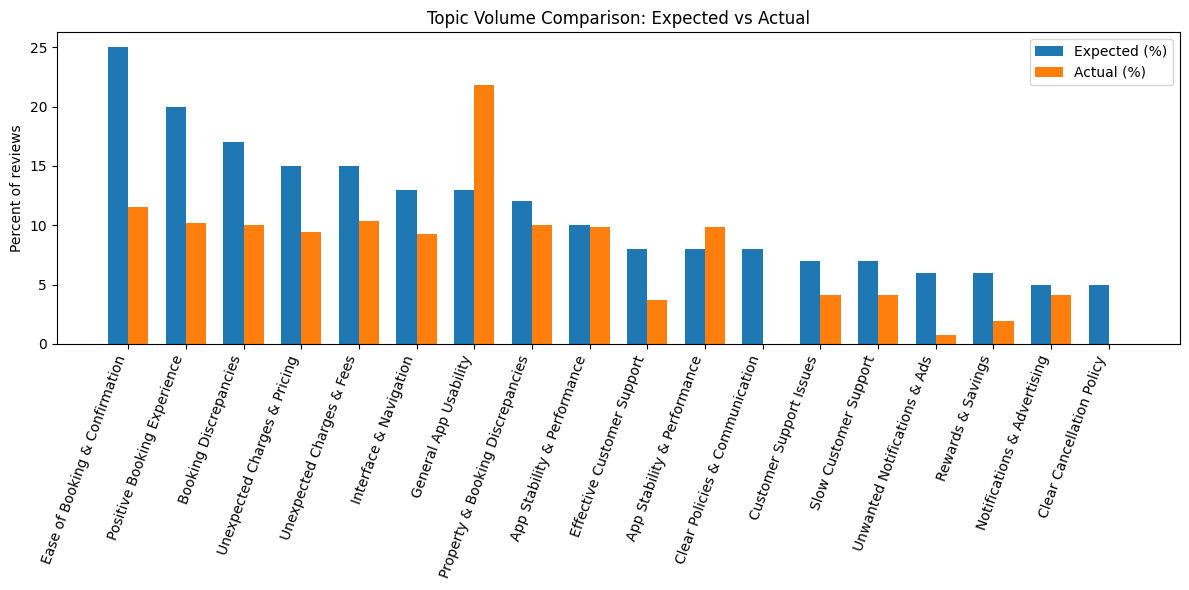

In [18]:
plot_df = topic_report.sort_values("expected_pct", ascending=False)

x = np.arange(len(plot_df))
w = 0.35

plt.figure(figsize=(12, 6))

# Bars
plt.bar(x - w/2, plot_df['expected_pct'], width=w, label='Expected (%)')
plt.bar(x + w/2, plot_df['actual_pct'], width=w, label='Actual (%)')

# Labels & style
plt.xticks(x, plot_df['subtopic'], rotation=70, ha='right')
plt.ylabel('Percent of reviews')
plt.title('Topic Volume Comparison: Expected vs Actual')
plt.legend()
plt.tight_layout()
plt.show()

The conclusion of this work is that the trained model distributes data quite accurately, but the greatest difficulties are caused by the differentiation of topics and the difference between neutral and negative sentiment.